In [1]:
#importing libraries
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr
import numpy as np
import os
import pandas as pd

In [2]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.9 MB/s eta 0:00:00


In [3]:
pip install rasterio

In [4]:
#access the google drive file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clippng by boundary and pixel size Function

In [5]:
#this function takes  input raster file that we want to clip, bounding box(xmin,xmax,ymin,ymax) and the pixel size as arguments
#rasterfile-input raster file (given by user)
#xmin,xamx,ymin,ymax- bounding box( given by user)
#res-pixel size of output raster (given by user)
#output file-final clipped raster location


def clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,res,output_file):
    """


    Args:
        raster_file: Path to the input raster file.
        xmin: Minimum x-coordinate of the bounding box.
        xmax: Maximum x-coordinate of the bounding box.
        ymin: Minimum y-coordinate of the bounding box.
        ymax: Maximum y-coordinate of the bounding box.
        output_file: Path to the output clipped raster file.
    """

    # Open the input raster file
    ds = gdal.Open(raster_file)

    # Get the raster's coordinate system
    srs = ds.GetProjection()

    # Create a new GeoTransform for the clipped raster
    gt = ds.GetGeoTransform()
    new_gt =(xmin,res,0,ymax,0,-res)

    # Create a new dataset for the clipped raster
    out_ds = gdal.GetDriverByName('GTiff').Create(
        output_file,
        int((xmax - xmin) /res),
        int((ymax - ymin) /res),
        1,   #ds.GetRasterCount()
        gdal.GDT_Float32
    )

    # Set the coordinate system and geotransform for the output dataset
    out_ds.SetProjection(srs)
    out_ds.SetGeoTransform(new_gt)

    # Copy the raster data from the input dataset to the output dataset
    gdal.Warp(out_ds,ds,cropToCutline=True,dstSRS=srs, dstNodata=np.nan)

    # Close the datasets
    ds = None
    out_ds = None

# TESTING

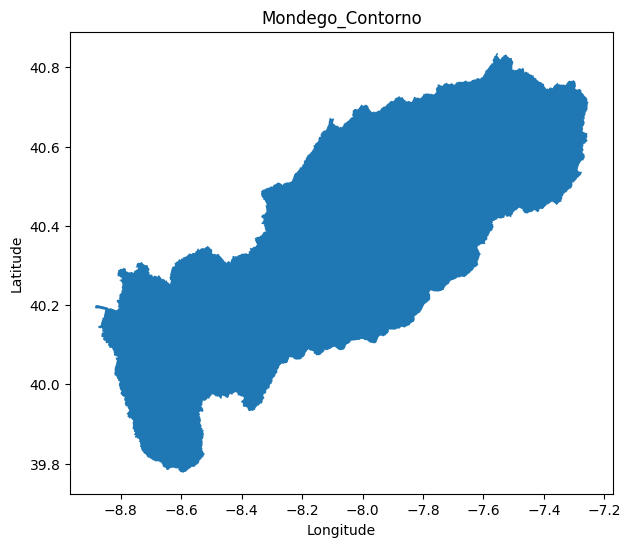

In [6]:
study_map_location=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'
study_map=gpd.read_file(study_map_location)
fig, ax=plt.subplots(1, figsize=(8,6))
study_map.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mondego_Contorno')
plt.show()

# Boundary

In [7]:
study_map=ogr.Open(f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp')
layer =study_map.GetLayer()
extent = layer.GetExtent()
xmin =extent[0]
xmax =extent[1]
ymin =extent[2]
ymax =extent[3]

# Test-1

In [8]:
#clipping dem raster file
raster_file=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/calculations from dem/mosa.tif'
output_file = f'/content/drive/MyDrive/clipping_by_function/clip_dem_by_bound.tif'
clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,0.004,output_file)

In [9]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_dem_by_bound.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of DEM file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of DEM file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


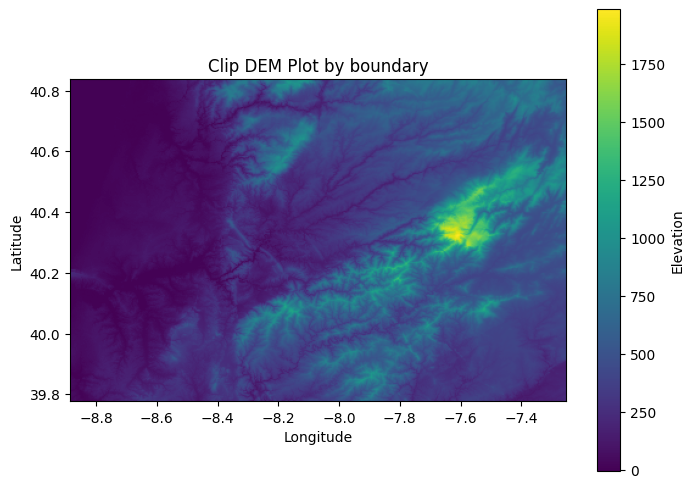

In [10]:
#visualize output file
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_dem_by_bound.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='Elevation')
plt.title('Clip DEM Plot by boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Clipping by STUDY AREA function

In [12]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

#function parameters

#raster_path-input raster file path            (given by user)
#shapefile_path-study area path                (given by user)
#output_path-output raster file path
#target_pixel_size-output raster pixel size    (given by user)


def clip_and_adjust_pixel_size(raster_path, shapefile_path, output_path, target_pixel_size):
    """
    Clip a raster file using a shapefile and adjust the pixel size to a specified value.

    Parameters:
    - raster_path: Path to the input raster file.
    - shapefile_path: Path to the shapefile used for clipping.
    - output_path: Path to the output clipped and adjusted raster file.
    - target_pixel_size: The desired pixel size for the output raster.
    """
    with rasterio.open(raster_path) as src:
        # Read the shapefile geometries
        gdf = gpd.read_file(shapefile_path)
        shapes = gdf.geometry

        # Get the bounding box of the shapefile
        shapefile_bounds = shapes.total_bounds
        left, bottom, right, top = shapefile_bounds

        # Calculate the new width and height based on the bounding box and the target pixel size
        new_width = int((right - left) / target_pixel_size)
        new_height = int((top - bottom) / target_pixel_size)

        # Calculate the new transform
        new_transform = rasterio.transform.from_origin(left, top, target_pixel_size, target_pixel_size)

        # Create an empty destination array to hold the resampled data
        destination = np.full((src.count, new_height, new_width), np.nan, dtype='float32')

        # First, reproject the entire raster to the new resolution
        for i in range(src.count):
            reproject(
                source=rasterio.band(src, i + 1),
                destination=destination[i],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=new_transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear
            )

        # Create mask from shapefile
        mask_array = rasterio.features.rasterize(
            shapes,
            out_shape=(new_height, new_width),
            transform=new_transform,
            fill=0,
            all_touched=True,
            default_value=1,
            dtype='uint8'
        )

        # Apply mask
        for i in range(src.count):
            destination[i][mask_array == 0] = np.nan

        # Update the metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": new_height,
            "width": new_width,
            "transform": new_transform,
            "dtype": 'float32',  # Ensure the output is in a floating-point type
            "nodata": np.nan
        })

        # Write the resampled and masked raster to the output file
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(destination)


# Test-1

In [15]:
#soil raster  file clipped by  study map
raster_file=f'/content/drive/MyDrive/clean_code_3/soil_raster.tif'   #input raster that we need to clip by study area
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'   #study area shape file
pixel_size=0.004     #target pixel size
output_file=f'/content/drive/MyDrive/clipping_by_function/clip_soil_raster_by_study_area.tif'  #output raster location

In [16]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [17]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_soil_raster_by_study_area.tif' )
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of Soil file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of Soil file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


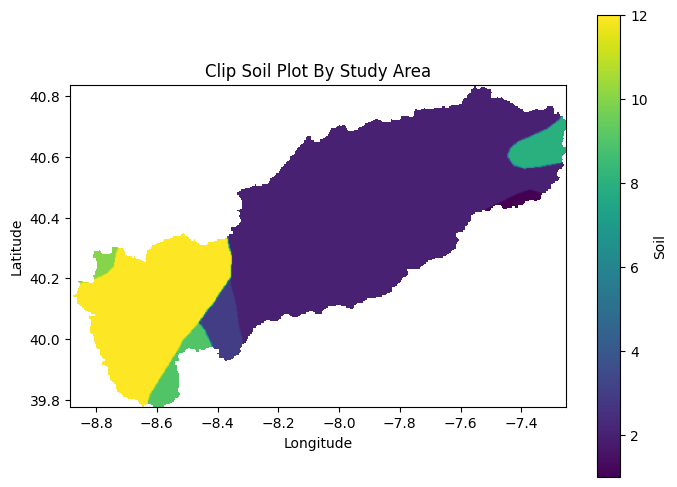

In [18]:
#visualize output raster
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_soil_raster_by_study_area.tif' )
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr,extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='Soil')
plt.title('Clip Soil Plot By Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Test-2

In [19]:
raster_file=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/calculations from dem/mosa.tif'
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'
pixel_size=0.004
output_file=f'/content/drive/MyDrive/clipping_by_function/clip_dem.tif'

In [20]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [21]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_dem.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size
ar2=raster.GetRasterBand(1).ReadAsArray()
print("Information of DEM file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of DEM file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


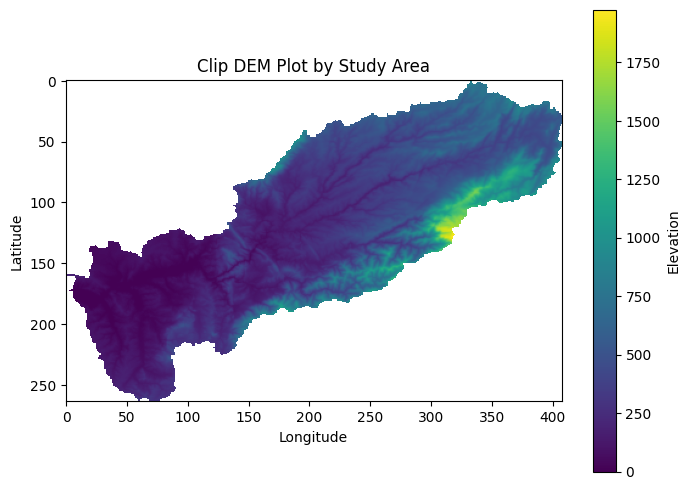

In [22]:
#visualize output raster
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/clip_dem.tif')
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr, cmap='viridis')
plt.colorbar(label='Elevation')
plt.title('Clip DEM Plot by Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Convert Shapefile (polygon) (class value) to Raster

In [23]:
#parameters:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)
#output_shape_file_location -the intermediate shape file location that is created in function for calculation purpose
#final_raster_location -the ouput clipped raster file location
#pixel - the pixel size of output raster file (given by user)


def shape_to_raster(input_shapefile,col,output_shape_file_location,final_raster_location,pixel):
  so=gpd.read_file(input_shapefile)
  a=so[col].nunique()
  b=so[col].unique()
  d={}
  so_c=so.copy()
  for i in range(1,a+1):
    prv_value=b[i-1]
    new_value=i
    d[prv_value]=new_value

  so_c[col]=so_c[col].replace(d).astype('int')

  gdf = gpd.GeoDataFrame(so_c,geometry=so_c['geometry'])
  gdf.to_file(output_shape_file_location)

  output_raster_location =final_raster_location
  pixel_size =pixel

  sh=ogr.Open(output_shape_file_location)
  source_layer=sh.GetLayer()
  xmin, xmax, ymin, ymax = source_layer.GetExtent()
  x_res = int(round((xmax - xmin) / pixel_size))
  y_res = int(round((ymax - ymin) / pixel_size))
  target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1,gdal.GDT_Float32, ['COMPRESS=LZW'])

  target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0,-pixel_size))
  srse = osr.SpatialReference()
  proj ='EPSG:4326'

  srse.SetWellKnownGeogCS(proj)

  target_ds.SetProjection(srse.ExportToWkt())
  band = target_ds.GetRasterBand(1)

  target_ds.GetRasterBand(1).SetNoDataValue(0)
  band.Fill(0)



  gdal.RasterizeLayer(target_ds,[1],source_layer, None, None,[1],options =['ALL_TOUCHED=TRUE', f'ATTRIBUTE={col}'])
  target_ds = None

# Testing

In [24]:
input_shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/Land Cover and vegetation/soil data FAO/soil_shape_clip.shp'
col='DOMSOI'
output_shape_file_location=f'/content/drive/MyDrive/clipping_by_function/soil_nume_shape.shp'
final_raster_location=f'/content/drive/MyDrive/clipping_by_function/soil_raster.tif'   #final result path
pixel=0.004

In [25]:
shape_to_raster(input_shapefile,col,output_shape_file_location,final_raster_location,pixel)

<ipython-input-23-9349c7ab6a1f>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  so_c[col]=so_c[col].replace(d).astype('int')


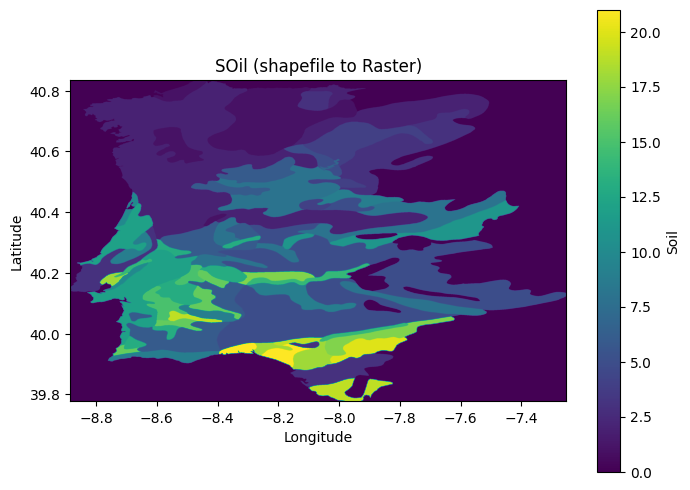

In [27]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/soil_raster.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='Soil')
plt.title('SOil (shapefile to Raster)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# for testing clipping(previous cell raster file) by bounday:

In [28]:
raster_file=f'/content/drive/MyDrive/clipping_by_function/soil_raster.tif'
output_file=f'/content/drive/MyDrive/clipping_by_function/soil_raster_clip_by_bound.tif'

In [29]:
clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,0.004,output_file)

In [30]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/soil_raster_clip_by_bound.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of Soil file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")   # for cliiping by boundary array size is same .so ok

Information of Soil file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


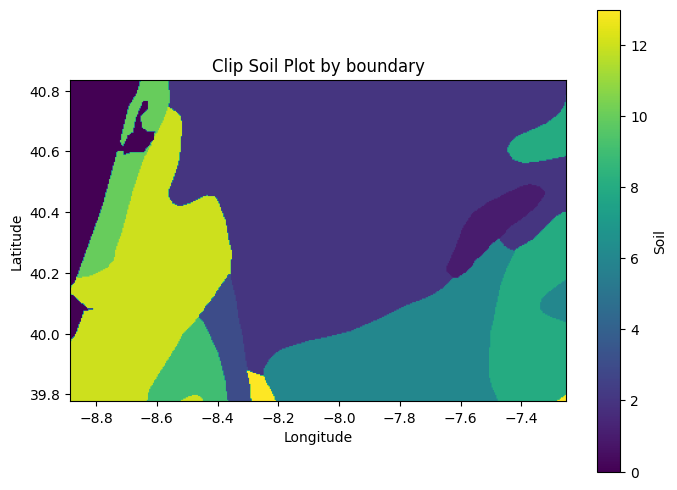

In [31]:
#visualize  output raster file
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/soil_raster_clip_by_bound.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='Soil')
plt.title('Clip Soil Plot by boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# for testing clipping by shape:

In [33]:
#soil raster  file clipped by  study map
raster_file=f'/content/drive/MyDrive/clipping_by_function/soil_raster.tif'   #input raster that we need to clip by study area
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'   #study area shape file
pixel_size=0.004     #target pixel size
output_file=f'/content/drive/MyDrive/clipping_by_function/poly_to_raster_soil_clip_by_study_area.tif'  #output raster location

In [34]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [35]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/poly_to_raster_soil_clip_by_study_area.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size
ar2=raster.GetRasterBand(1).ReadAsArray()
print("Information of soil file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of soil file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


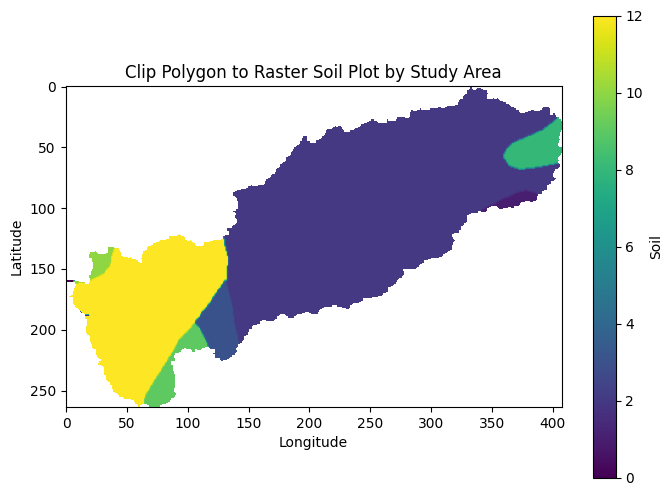

In [36]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/poly_to_raster_soil_clip_by_study_area.tif')
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr, cmap='viridis')
plt.colorbar(label='Soil')
plt.title('Clip Polygon to Raster Soil Plot by Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Shape file (Point) numeric to Raster

**point shape file of Precipitation**

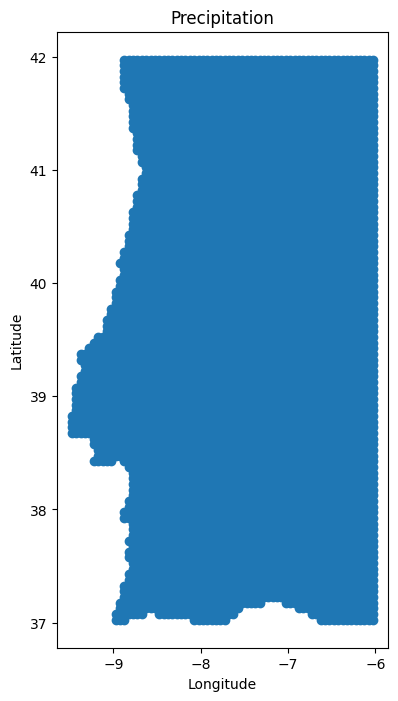

In [37]:
#input file
precip_point=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/Land Cover and vegetation/precipitation/percip_point.shp'
csa=gpd.read_file(precip_point)
fig, ax=plt.subplots(1, figsize=(8,8))
csa.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation')
plt.show()

# function - point shape file to raster conversion

In [38]:
#output raster-the final raster file location
#field_name -the target field or column of attribute table/ geooandas dataframe (given by user)
#input file -the input shape file (given by user)
#xmin,ymax,xmax,ymin- boundary given by users or need to extract from the study area shape file
#pixel - the pixel size of output raster file (given by user)

def point_shape_to_raster(output_raster,field_name,input_file,xmin,ymax,xmax,ymin,pixel):
  xsize=int(abs((xmax-xmin)/pixel))
  ysize=int(abs((ymax-ymin)/pixel))
  idw=gdal.Grid(output_raster,input_file, zfield=field_name, algorithm= "invdist:power=2",
                outputBounds =[xmin,ymax,xmax,ymin], width= xsize, height=ysize)

  idw=None
  idw=None

# Testing

# how to get function parameters of boundary

In [40]:
#from user giving
#from study map
study_map=ogr.Open(f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp')
layer =study_map.GetLayer()
extent = layer.GetExtent()
xmin =extent[0]
xmax =extent[1]
ymin =extent[2]
ymax =extent[3]

In [43]:
output_raster=f'/content/drive/MyDrive/clipping_by_function/precipitation_map_interp.tif'  #output raster location
input_file=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/Land Cover and vegetation/precipitation/percip_point.shp'  #input file
field_name='precip'   #column name or target attribute
pixel=0.004   #output raster pixel

In [44]:
point_shape_to_raster(output_raster,field_name,input_file,xmin,ymax,xmax,ymin,pixel)

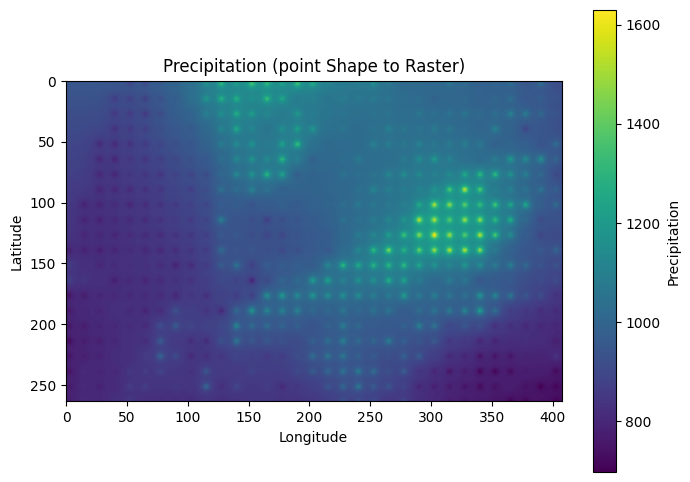

In [45]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/precipitation_map_interp.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray())
plt.colorbar(label='Precipitation')
plt.title('Precipitation (point Shape to Raster)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# for testing clipping(previous cell raster) by boundary

In [47]:
raster_file=f'/content/drive/MyDrive/clipping_by_function/precipitation_map_interp.tif'
output_file=f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_bound.tif'

In [49]:
clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,0.004,output_file)

In [50]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_bound.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of Precipitation  file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")   # for cliiping by boundary array size is same .so ok

Information of Precipitation  file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


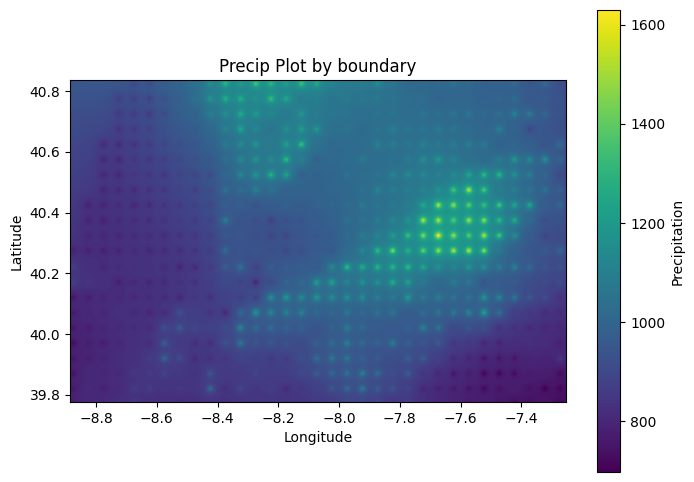

In [51]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_bound.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='Precipitation')
plt.title('Precip Plot by boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# for testing clipping by Study Area

In [52]:
raster_file=f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_bound.tif'
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'
pixel_size=0.004
output_file=f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_study_area.tif'

In [54]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [55]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_study_area.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size
ar2=raster.GetRasterBand(1).ReadAsArray()
print("Information of Precipitation file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of Precipitation file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


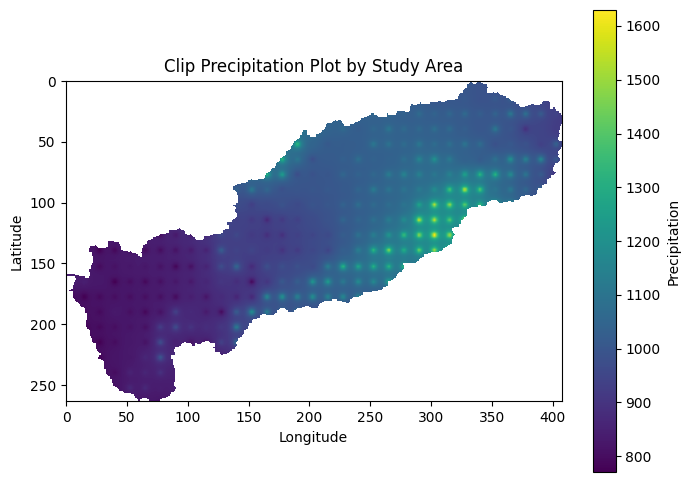

In [56]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/precipitation_map_clip_by_study_area.tif')
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr, cmap='viridis')
plt.colorbar(label='Precipitation')
plt.title('Clip Precipitation Plot by Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# shape file (polygon) numeric to Raster

In [57]:
# input shape file
poly_val=gpd.read_file(f'/content/drive/MyDrive/clean code test/ploy_num.shp')
poly_val.head(2)

,SNUM,FAOSOIL,DOMSOI,PHASE1,PHASE2,MISCLU1,MISCLU2,PERMAFROST,CNTCODE,CNTNAME,SQKM,COUNTRY,new,geometry
0,6639,U4-2bc,U,01,None,0,0,0,203,SP,1473.0,CANARIAS (SPAIN),1,"POLYGON ((-7.60062 43.65969, -7.62346 43.60508..."
1,3024,Bh25-2bc,Bh,01,None,0,0,0,203,SP,18844.0,CANARIAS (SPAIN),2,"POLYGON ((-7.03102 43.43627, -7.05777 43.41553..."


In [58]:
#parameters:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)
#final_raster_location -the ouput clipped raster file location
#pixel_size - the pixel size of output raster file (given by user)



def shape_poly_val_to_raster(input_shapefile,col,final_raster_location,pixel_size):


  sh=ogr.Open(input_shapefile)
  source_layer=sh.GetLayer()
  xmin, xmax, ymin, ymax = source_layer.GetExtent()
  x_res = int(round((xmax - xmin) / pixel_size))
  y_res = int(round((ymax - ymin) / pixel_size))
  target_ds = gdal.GetDriverByName('GTiff').Create(final_raster_location, x_res, y_res, 1,gdal.GDT_Float32, ['COMPRESS=LZW'])

  target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0,-pixel_size))
  srse = osr.SpatialReference()
  proj ='EPSG:4326'

  srse.SetWellKnownGeogCS(proj)

  target_ds.SetProjection(srse.ExportToWkt())
  band = target_ds.GetRasterBand(1)

  target_ds.GetRasterBand(1).SetNoDataValue(0)
  band.Fill(0)



  gdal.RasterizeLayer(target_ds,[1],source_layer, None, None,[1],options =['ALL_TOUCHED=TRUE', f'ATTRIBUTE={col}'])
  target_ds = None

In [59]:
input_shapefile=f'/content/drive/MyDrive/clean code test/ploy_num.shp'                           #input shape file path
final_raster_location=f'/content/drive/MyDrive/clipping_by_function/ploy_num.tif'                #output raster path
col='new'                                                                                        #target column  or attribute
pixel_size=0.004                                                                                 #target pixel

In [60]:
shape_poly_val_to_raster(input_shapefile,col,final_raster_location,pixel_size)

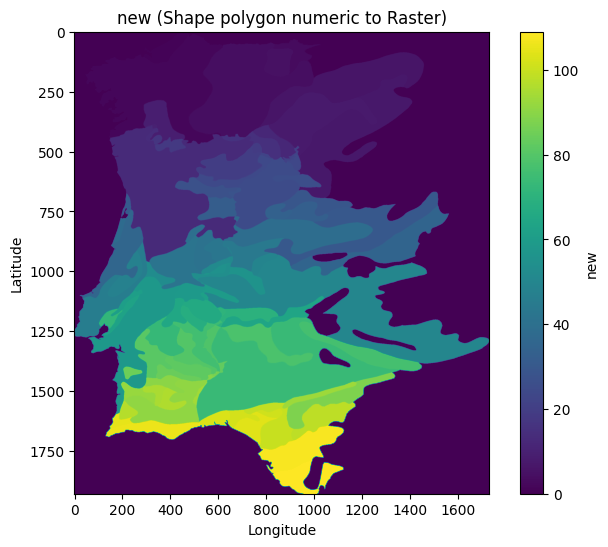

In [62]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/ploy_num.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray())
plt.colorbar(label='new')
plt.title('new (Shape polygon numeric to Raster)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## for testing (previous cell raster) clipping  by boundary

In [65]:
raster_file=f'/content/drive/MyDrive/clipping_by_function/ploy_num.tif'                       #input shape file path
output_file=f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_bound.tif'         #output shape file path

In [66]:
clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,0.004,output_file)

In [67]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_bound.tif' )
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of new file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")   # for cliiping by boundary array size is same .so ok

Information of new file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


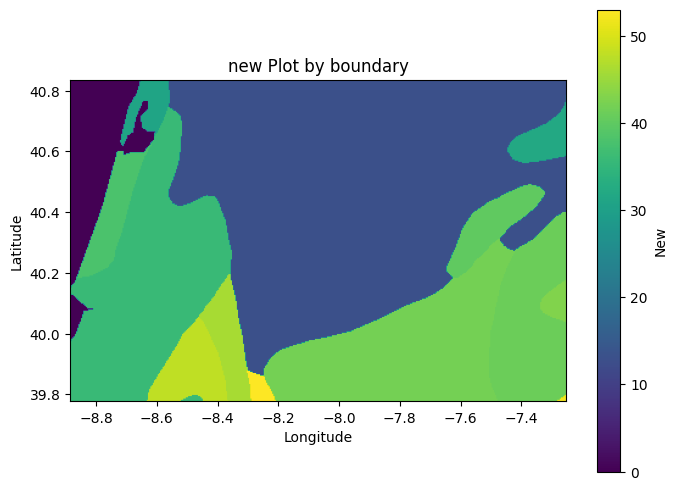

In [68]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_bound.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='New')
plt.title('new Plot by boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# for testing clipping by shape

In [70]:
#soil raster  file clipped by  study map
raster_file=f'/content/drive/MyDrive/clipping_by_function/ploy_num.tif'    #input raster that we need to clip by study area
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'   #study area shape file
pixel_size=0.004     #target pixel size
output_file=f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_study_area.tif'  #output raster location

In [71]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [72]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_study_area.tif' )
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size
ar2=raster.GetRasterBand(1).ReadAsArray()
print("Information of New file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of New file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


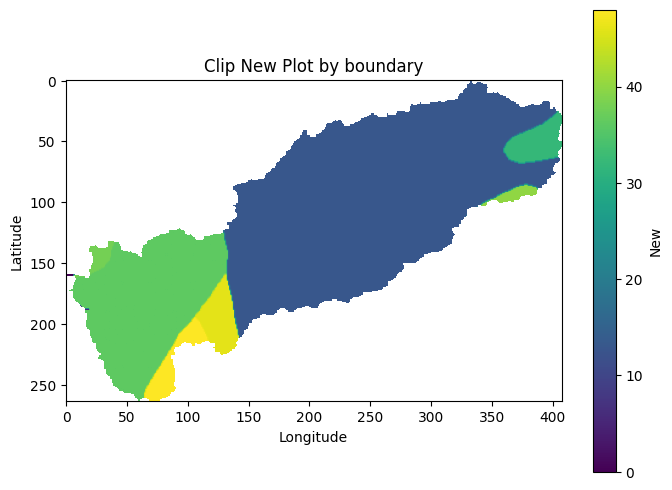

In [79]:
raster=gdal.Open(f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_study_area.tif')
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr, cmap='viridis')
plt.colorbar(label='New')
plt.title('Clip New Plot by boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Check the shape file type and column type

In [75]:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)

def check_type(input_shape_file,col):
  data=gpd.read_file(input_shape_file)
  file_type=str(data['geometry'][0]).split(' ')[0]

  col_type=data[col].dtype
  print(f'Shape file type : {file_type}')
  print(f'Target Field type : {col_type}')

In [76]:
input_shape_file=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/Land Cover and vegetation/precipitation/percip_point.shp'

In [77]:
check_type(input_shape_file,'precip')

Shape file type : POINT
Target Field type : float64


# Find the max , min of a Raster file

In [92]:
def max_min(raster_file):
  raster=gdal.Open(raster_file)
  data=raster.GetRasterBand(1).ReadAsArray()
  max=data[~np.isnan(data)].max()   #remove null values and find max
  min=data[~np.isnan(data)].min()   #remove null values and find min
  return max,min

In [94]:
raster_path=f'/content/drive/MyDrive/clipping_by_function/ploy_num_clip_by_study_area.tif'
result=max_min(raster_path)
print(f'Max = {result[0]}')
print(f'Min = {result[1]}')

Max = 48.0
Min = 0.0
